Loading the input data from the file and checking the data 

In [1]:
import numpy as np 
import pandas as pd 
import os,cv2
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
import shutil

from keras import optimizers
from keras.models import Model
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import applications


/home/vigneshk/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


###Using a function to split the dataset into train and val directoires

In [2]:
def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
    # Recreate testing and training directories
    if testing_data_dir.count('/') > 1:
        shutil.rmtree(testing_data_dir, ignore_errors=False)
        os.makedirs(testing_data_dir)
        print("Successfully cleaned directory " + testing_data_dir)
    else:
        print("Refusing to delete testing data directory " + testing_data_dir + " as we prevent you from doing stupid things!")

    if training_data_dir.count('/') > 1:
        shutil.rmtree(training_data_dir, ignore_errors=False)
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory " + training_data_dir)
    else:
        print("Refusing to delete testing data directory " + training_data_dir + " as we prevent you from doing stupid things!")

    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        for file in files:
            input_file = os.path.join(subdir, file)
            if np.random.rand(1) < testing_data_pct:
                shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
                num_testing_files += 1
            else:
                shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
                num_training_files += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")
    return num_training_files, num_testing_files

In [3]:
# Preparing training data
dirs = os.listdir("/home/vigneshk/datasets/train")

#Splitting the training dataset into train and val to give it to image datagenerator
training_size, validation_size = split_dataset_into_test_and_train_sets('/home/vigneshk/datasets/train','/home/vigneshk/datasets/train_split',
                                      '/home/vigneshk/datasets/val_split',0.1)


Successfully cleaned directory /home/vigneshk/datasets/val_split
Successfully cleaned directory /home/vigneshk/datasets/train_split
train vs train
Shepherds Purse vs train
Charlock vs train
Scentless Mayweed vs train
Common Chickweed vs train
Black-grass vs train
Loose Silky-bent vs train
Fat Hen vs train
Common wheat vs train
Cleavers vs train
Sugar beet vs train
Maize vs train
Small-flowered Cranesbill vs train
Processed 4239 training files.
Processed 511 testing files.


In [8]:
#Defining the train and val data generators

batch_size = 16
img_size = 300

train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True)

val_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True)

train_dir = '/home/vigneshk/datasets/train_split'
val_dir = '/home/vigneshk/datasets/val_split'

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_size,img_size), batch_size=batch_size)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(img_size,img_size), batch_size=batch_size)

indices = train_generator.class_indices
weights_path = '/home/vigneshk/datasets/weights/xception_weights.{epoch:02d}-{val_loss:.2f}.hdf5'

print(indices)

epochs = 50
learning_rate = 0.0001

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0),
             ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, verbose=0),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)]

base_model = applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg') # Average pooling reduces output dimensions
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

print model.summary()

Found 4239 images belonging to 12 classes.
Found 511 images belonging to 12 classes.
{'Cleavers': 2, 'Maize': 7, 'Small-flowered Cranesbill': 10, 'Loose Silky-bent': 6, 'Common Chickweed': 3, 'Common wheat': 4, 'Black-grass': 0, 'Sugar beet': 11, 'Charlock': 1, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Fat Hen': 5}
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0] 

Fine Tuning the pretrained model 

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

# ------ TRAINING ------
model.fit_generator(train_generator,
                    steps_per_epoch=(training_size//batch_size)+1, 
                    validation_data=val_generator, 
                    validation_steps=(validation_size//batch_size)+1,
                    callbacks=callbacks,
                    epochs=epochs, 
                    verbose=1)

model.save('/home/vigneshk/datasets/models/xception_350_.h5')

Epoch 1/50
265/265 [==============================] - 308s 1s/step - loss: 0.8431 - acc: 0.7472 - val_loss: 0.2181 - val_acc: 0.9237
Epoch 2/50
265/265 [==============================] - 302s 1s/step - loss: 0.2104 - acc: 0.9306 - val_loss: 0.1776 - val_acc: 0.9472
Epoch 3/50
265/265 [==============================] - 302s 1s/step - loss: 0.1421 - acc: 0.9552 - val_loss: 0.1743 - val_acc: 0.9472
Epoch 4/50
265/265 [==============================] - 301s 1s/step - loss: 0.1129 - acc: 0.9675 - val_loss: 0.1904 - val_acc: 0.9511
Epoch 5/50
265/265 [==============================] - 301s 1s/step - loss: 0.0819 - acc: 0.9743 - val_loss: 0.1758 - val_acc: 0.9550
Epoch 6/50
265/265 [==============================] - 301s 1s/step - loss: 0.0629 - acc: 0.9809 - val_loss: 0.1559 - val_acc: 0.9530
Epoch 7/50
265/265 [==============================] - 302s 1s/step - loss: 0.0585 - acc: 0.9807 - val_loss: 0.2044 - val_acc: 0.9452
Epoch 8/50
265/265 [==============================] - 302s 1s/step - 

In [ ]:
## Checking and plotting the training and validation loss 

In [10]:
history = model.history 
print (history.history)

{'acc': [0.747110167492333, 0.9306440198441164, 0.9551781080443501, 0.967445152158528, 0.9742863882991272, 0.9808917197452229, 0.9806558150507195, 0.9867893371218694, 0.9917433356923803, 0.9936305732484076, 0.9962255248879452, 0.9966973342769521, 0.998348667138476, 0.9981127624439726, 0.9978768577494692, 0.9995281906109932, 0.9995281906109932, 0.998348667138476], 'loss': [0.8433008357604794, 0.21038089380438077, 0.1420865317754532, 0.11296974952168118, 0.08193020284567823, 0.062859678297785, 0.058518438376455546, 0.044780913654053074, 0.03029238006403414, 0.02426632323672968, 0.013795073357414903, 0.013160730150087088, 0.009769625886834237, 0.009482992144873201, 0.009059177341186149, 0.004985732431764626, 0.0053634630371936194, 0.006884114262912669], 'val_acc': [0.9236790607820051, 0.9471624268477676, 0.9471624267311245, 0.9510763209393346, 0.954990215380831, 0.9530332681017613, 0.9452054794520548, 0.9491193738935512, 0.939334638081418, 0.9608610567514677, 0.9628180039138943, 0.9589041

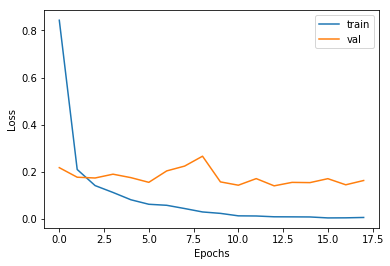

In [12]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt
plt.plot(train_loss,label="train")
plt.plot(val_loss,label="val")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('/home/vigneshk/datasets/plots/Xception_loss_.jpeg')

In [13]:
dim =300 
x_test = []
df_test = pd.read_csv('/home/vigneshk/datasets/sample_submission.csv')

for f, species in tqdm(df_test.values, miniters=100):
    img = cv2.imread('/home/vigneshk/datasets/test/{}'.format(f))
    x_test.append(cv2.resize(img, (dim, dim)))

x_test = np.array(x_test, np.float32)
print(x_test.shape)

# if os.path.isfile(xception_100_ep.h5):
model.load_weights('/home/vigneshk/datasets/weights/xception_weights.13-0.14.hdf5')

p_test = model.predict(x_test, verbose=1)

print p_test

preds = []
for i in range(len(p_test)):
    pos = np.argmax(p_test[i])
    print pos 
    preds.append(list(indices.keys())[list(indices.values()).index(pos)])
    
df_test['species'] = preds
df_test.to_csv('/home/vigneshk/datasets/submissions/xception_300_13eps.csv', index=False)

100%|██████████| 794/794 [00:02<00:00, 332.02it/s]


(794, 300, 300, 3)
794/794 [==============================] - 19s 24ms/step
[[3.0494174e-03 1.1187362e-04 7.9252507e-04 ... 1.0092727e-05
  9.9474299e-01 7.4079537e-05]
 [4.1302966e-04 1.5691390e-04 4.2033145e-05 ... 1.8406419e-05
  6.8650843e-05 2.3065663e-04]
 [1.6152932e-06 3.3769300e-06 5.4231873e-06 ... 1.8267415e-06
  1.6474568e-06 1.0309453e-04]
 ...
 [3.6947042e-04 1.2956565e-04 3.7932364e-04 ... 8.3069383e-05
  4.9949100e-05 1.5692763e-02]
 [1.1043907e-06 9.9992394e-01 8.3562531e-07 ... 3.2659176e-07
  9.1379775e-07 6.1853264e-08]
 [1.5079996e-05 9.4044015e-07 1.0486516e-06 ... 1.8404015e-07
  1.0778313e-06 4.3210042e-07]]
10
4
4
3
4
0
3
4
0
6
5
2
4
8
4
5
3
2
2
2
3
10
2
4
4
7
4
8
3
4
3
2
0
4
6
0
0
0
3
7
0
4
2
10
4
4
7
8
7
10
6
4
2
6
7
4
1
10
2
0
4
2
1
4
7
4
0
0
2
8
10
3
8
2
3
4
0
3
3
6
4
2
3
4
2
4
2
8
4
0
1
0
4
0
3
6
2
8
7
2
5
4
8
4
5
4
3
2
2
2
0
1
3
2
2
4
2
1
4
3
3
4
2
0
7
4
1
7
5
3
4
11
3
2
4
4
5
1
0
3
6
10
2
3
5
4
4
10
4
1
8
6
7
0
6
10
3
4
0
2
1
0
3
2
9
6
6
4
3
3
9
7
2
3
3
